# Energy Demand Forecasting — PJM (AEP region)

Author: Shreya Sati   
Theme: Sustainable Energy & Efficiency

This notebook is pre-configured for `AEP_hourly.csv` (PJM dataset). It trains
Linear Regression, Random Forest and LSTM model for forecasting.


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true==0, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [2]:
# CONFIG
DATA_FILE = 'AEP_hourly.csv'
USE_LSTM = True              
LSTM_SEQ_HOURS = 48          
LSTM_EPOCHS = 8              
LSTM_BATCH_SIZE = 64
RECENT_YEARS_FOR_LSTM = 2    


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])

# Clean and rename columns
df.columns = df.columns.str.strip()
df.rename(columns={'Datetime': 'timestamp', 'AEP_MW': 'energy'}, inplace=True)

# Sort and reset index
df = df.sort_values('timestamp').reset_index(drop=True)

print(df.columns.tolist())
print(df.head())


['timestamp', 'energy']
            timestamp   energy
0 2004-10-01 01:00:00  12379.0
1 2004-10-01 02:00:00  11935.0
2 2004-10-01 03:00:00  11692.0
3 2004-10-01 04:00:00  11597.0
4 2004-10-01 05:00:00  11681.0


In [4]:
print("Columns in df:", df.columns.tolist())
print(df.head())


Columns in df: ['timestamp', 'energy']
            timestamp   energy
0 2004-10-01 01:00:00  12379.0
1 2004-10-01 02:00:00  11935.0
2 2004-10-01 03:00:00  11692.0
3 2004-10-01 04:00:00  11597.0
4 2004-10-01 05:00:00  11681.0


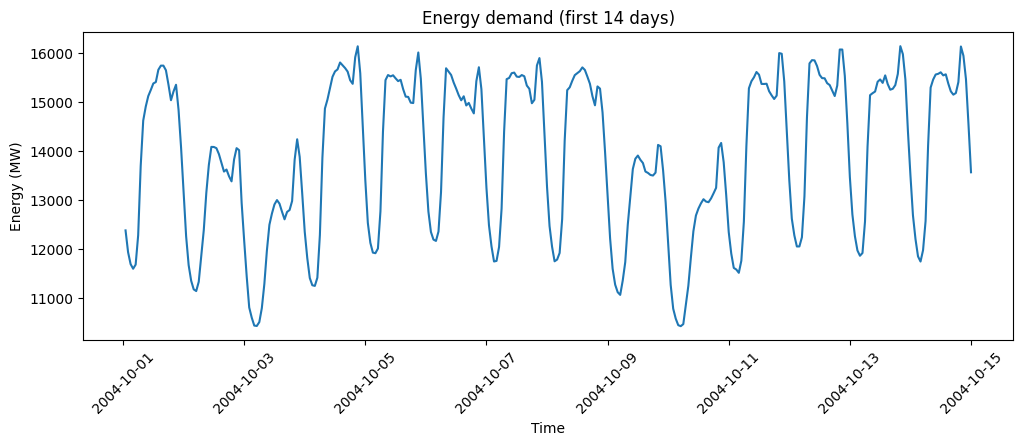

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['timestamp'].iloc[:24*14].values, df['energy'].iloc[:24*14].values)
plt.title('Energy demand (first 14 days)')
plt.xlabel('Time')
plt.ylabel('Energy (MW)')
plt.xticks(rotation=45)
plt.show()


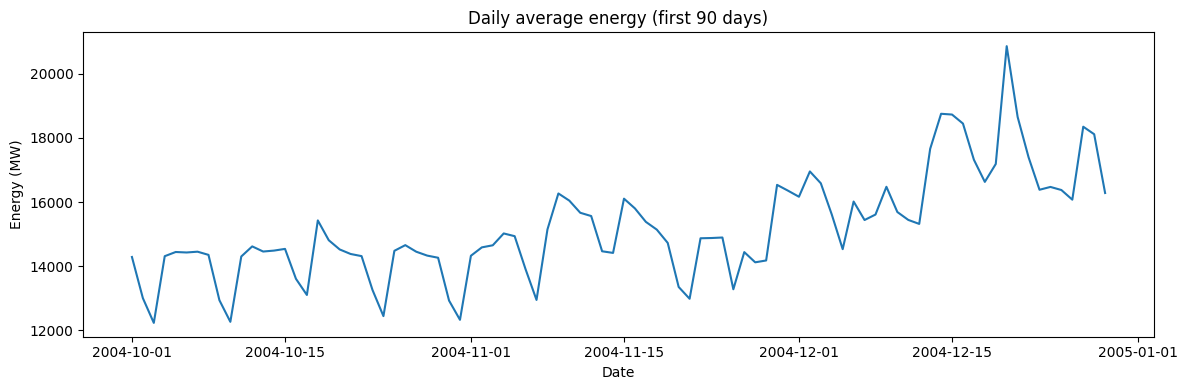

In [6]:



df_daily = df.set_index('timestamp').resample('D').mean().reset_index()
plt.figure(figsize=(12,4))
plt.plot(df_daily['timestamp'].iloc[:90], df_daily['energy'].iloc[:90])
plt.title('Daily average energy (first 90 days)')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.tight_layout()
plt.show()


In [7]:
df_fe = df.copy()
df_fe['hour'] = df_fe['timestamp'].dt.hour
df_fe['dayofweek'] = df_fe['timestamp'].dt.dayofweek
df_fe['month'] = df_fe['timestamp'].dt.month
for lag in [1,24,168]:
    df_fe[f'lag_{lag}'] = df_fe['energy'].shift(lag)
df_fe['rmean_24'] = df_fe['energy'].rolling(window=24).mean().shift(1)
df_fe['rmean_168'] = df_fe['energy'].rolling(window=168).mean().shift(1)
df_fe = df_fe.dropna().reset_index(drop=True)
print('After feature engineering length:', len(df_fe))
df_fe.head()


After feature engineering length: 121105


,timestamp,energy,hour,dayofweek,month,lag_1,lag_24,lag_168,rmean_24,rmean_168
0,2004-10-08 01:00:00,12468.0,1,4,10,13271.0,12484.0,12379.0,14450.333333,13870.315476
1,2004-10-08 02:00:00,12046.0,2,4,10,12468.0,12054.0,11935.0,14449.666667,13870.845238
2,2004-10-08 03:00:00,11749.0,3,4,10,12046.0,11745.0,11692.0,14449.333333,13871.505952
3,2004-10-08 04:00:00,11784.0,4,4,10,11749.0,11757.0,11597.0,14449.500000,13871.845238
4,2004-10-08 05:00:00,11919.0,5,4,10,11784.0,12041.0,11681.0,14450.625000,13872.958333


In [8]:
train_size = int(0.8 * len(df_fe))
train = df_fe.iloc[:train_size].copy()
test = df_fe.iloc[train_size:].copy()
features = ['lag_1','lag_24','lag_168','rmean_24','rmean_168','hour','dayofweek','month']
target = 'energy'
X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (96884, 8) Test shape: (24221, 8)


Linear Regression RMSE: 479.5047413620399
Linear Regression MAPE: 2.5872781008666546
Random Forest RMSE: 245.4342506234112
Random Forest MAPE: 1.2295690654636107


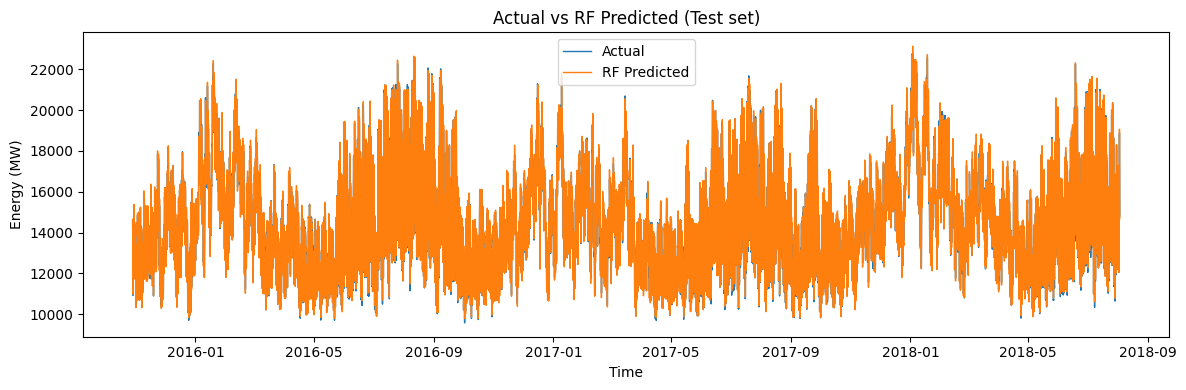

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
print('Linear Regression RMSE:', rmse(y_test, pred_lr))
print('Linear Regression MAPE:', mape(y_test, pred_lr))
rf = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print('Random Forest RMSE:', rmse(y_test, pred_rf))
print('Random Forest MAPE:', mape(y_test, pred_rf))
plt.figure(figsize=(12,4))
plt.plot(test['timestamp'].values, y_test, label='Actual', linewidth=1)
plt.plot(test['timestamp'].values, pred_rf, label='RF Predicted', linewidth=1)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy (MW)')
plt.title('Actual vs RF Predicted (Test set)')
plt.tight_layout()
plt.show()


TensorFlow version: 2.20.0
Using recent slice for LSTM from 2016-08-03 to 2018-08-03 length: 17521
LSTM seq shapes: (13978, 48, 8) (3495, 48, 8)
Epoch 1/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 222056912.0000 - val_loss: 220386368.0000
Epoch 2/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 214683712.0000 - val_loss: 210028896.0000
Epoch 3/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 201679152.0000 - val_loss: 194441568.0000
Epoch 4/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 184061168.0000 - val_loss: 174891696.0000
Epoch 5/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 163266464.0000 - val_loss: 152856576.0000
Epoch 6/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 140661888.0000 - val_loss: 129701904.0000
Epoch 7/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 117678704.0000 - val_loss: 106740432.0000
Epoch 8/8
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 95260944.0000 - val_loss: 85049664.0000
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/st

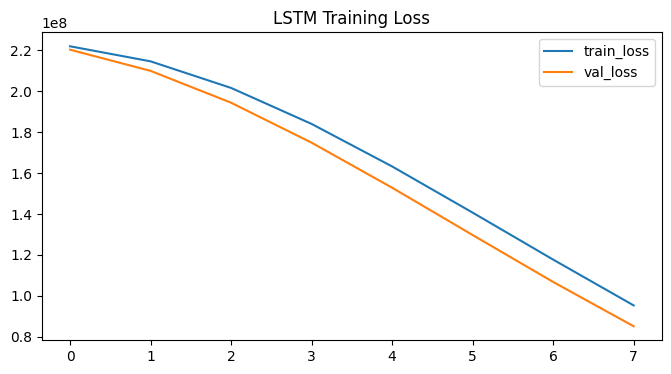

In [10]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    TF_AVAILABLE = True
    print('TensorFlow version:', tf.__version__)
except Exception as e:
    print('TensorFlow not available. LSTM will be skipped. Error:', e)
    TF_AVAILABLE = False

if USE_LSTM and TF_AVAILABLE:
    df_lstm = df_fe.copy()
    if RECENT_YEARS_FOR_LSTM is not None:
        last_date = df_lstm['timestamp'].max()
        cutoff = last_date - pd.DateOffset(years=RECENT_YEARS_FOR_LSTM)
        df_lstm = df_lstm[df_lstm['timestamp'] >= cutoff].reset_index(drop=True)
        print('Using recent slice for LSTM from', cutoff.date(), 'to', last_date.date(), 'length:', len(df_lstm))
    X_all = df_lstm[features].values
    y_all = df_lstm[target].values
    scaler_lstm = StandardScaler()
    X_all_scaled = scaler_lstm.fit_transform(X_all)
    def create_sequences(X, y, seq_len=LSTM_SEQ_HOURS):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i-seq_len:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)
    X_seq, y_seq = create_sequences(X_all_scaled, y_all, seq_len=LSTM_SEQ_HOURS)
    split_idx = int(0.8 * len(X_seq))
    X_seq_train, X_seq_test = X_seq[:split_idx], X_seq[split_idx:]
    y_seq_train, y_seq_test = y_seq[:split_idx], y_seq[split_idx:]
    print('LSTM seq shapes:', X_seq_train.shape, X_seq_test.shape)
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_seq_train, y_seq_train, epochs=LSTM_EPOCHS, batch_size=LSTM_BATCH_SIZE, validation_data=(X_seq_test, y_seq_test))
    pred_lstm = model.predict(X_seq_test).flatten()
    print('LSTM RMSE:', rmse(y_seq_test, pred_lstm))
    print('LSTM MAPE:', mape(y_seq_test, pred_lstm))
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('LSTM Training Loss')
    plt.legend()
    plt.show()
else:
    print('Skipping LSTM (USE_LSTM=False or TensorFlow not available)')


In [11]:
os.makedirs('./artifacts', exist_ok=True)
joblib.dump(scaler, './artifacts/scaler.joblib')
joblib.dump(rf, './artifacts/random_forest.joblib')
print('Saved artifacts to ./artifacts')


Saved artifacts to ./artifacts


## Conclusion & Next steps
- Replace dataset with other PJM region CSVs to compare regions.  
- For production or larger experiments use cross-validation with time-series splits and hyperparameter tuning.  
- If adding weather features, merge hourly weather by timestamp.

End of notebook.